# CAM Visualization

In this notebook we perform the visualization of the class activation maps of our pretrained CNN, superimposing them to the imput images in order to establish which parts of the images are used for classification.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PieTempesti98/CNNMalariaDetector/blob/master/CAM_visualization.ipynb)


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras as ks
from sklearn import metrics
import os
import matplotlib.cm as cm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/cidl_project'
IMAGE_PATH = DRIVE_PATH + '/sample_images'
MODELS_PATH =  DRIVE_PATH + '/models'
MODEL_NAME = 'HPO_model'
AUTO = tf.data.experimental.AUTOTUNE
SEED = 20
img_path_2 = ks.utils.get_file(fname= 'sample3.png', origin='https://knowyourdata-tfds.withgoogle.com/serve_image?id=train%5B0shard%5D_5708&segment_name=default_segment&pipeline_id=20220622-99c6dc&cachebust=N02IAMoc&dataset=malaria')

In [ ]:
# set always the same seed i order to obtain reproducible results
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Class Activation Map visualization

In this experiment, our aim is to visualize which parts of a given sample will be used by the network to establish if the cell is parasitized.
This visualization technique can help medical division to understand the classifier output, learning the infected sections of the cell or noticing a misclassification.

# Model load and settings

In [ ]:
model = ks.models.load_model(MODELS_PATH + '/' + MODEL_NAME + '.h5')
model.summary()

Model: "optimized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)   

In [ ]:
# name of the last convolutional layer
last_conv_layer_name =  'conv2d_7' # output shape (x, 5, 5, 256)

classifier_layer_names = [ 
    'max_pooling2d_7',
    'flatten_1',
    'dense_2',
    "dense_3",            # output of the whole network
]

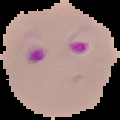

In [ ]:
img = ks.utils.load_img(img_path_2, target_size=(120,120))
array = ks.utils.img_to_array(img)
array = np.expand_dims(array, axis=0)

img

# CAM pipeline

In [ ]:
def cam_pipeline(image, fname, image_name):
    array = ks.utils.img_to_array(image)
    array = np.expand_dims(array, axis=0)
    preds = model.predict(array)
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = ks.Model(model.inputs, last_conv_layer.output)
    classifier_input = ks.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = ks.Model(classifier_input, x)
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(array) # output feature maps of the last conv layer.
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:,0]

    grads = tape.gradient(top_class_channel, last_conv_layer_output) # gradient of the "parasitized" class with regard to the output feature maps of our last conv layer
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2, 3)).numpy() # evaluate the mean over the gradient tensor, for each channel separately --> returns a vector of 256 elements
    weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]):
        weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)

    img = ks.utils.load_img(image_name)
    img = ks.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = ks.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = ks.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = ks.utils.array_to_img(superimposed_img[1:,:])

    save_path = "/" + fname
    superimposed_img.save(IMAGE_PATH + save_path)
    return superimposed_img

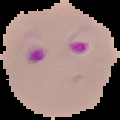

In [ ]:
image1_name = 'sample1.png'
image1 = ks.utils.get_file(fname=image1_name , origin='https://knowyourdata-tfds.withgoogle.com/serve_image?id=train%5B0shard%5D_5708&segment_name=default_segment&pipeline_id=20220622-99c6dc&cachebust=N02IAMoc&dataset=malaria')

img = ks.utils.load_img(image1, target_size=(120,120))
array = ks.utils.img_to_array(img)
array = np.expand_dims(array, axis=0)

img

1/1 [==============================] - 0s 135ms/step


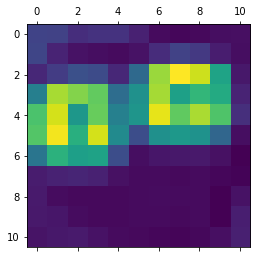

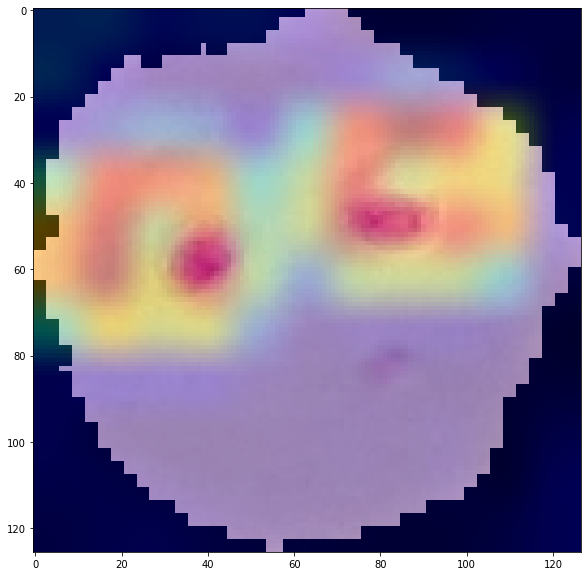

In [ ]:
cam_img = cam_pipeline(img, 'cam1.jpg', image1)
plt.figure(figsize= (10,10))
plt.imshow(cam_img)

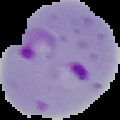

In [ ]:
image2_name = 'sample2.png'
image2 = ks.utils.get_file(fname=image2_name , origin='https://knowyourdata-tfds.withgoogle.com/serve_image?id=train%5B2shard%5D_4287&segment_name=default_segment&pipeline_id=20220622-99c6dc&cachebust=Gp-nuVij&dataset=malaria')

img = ks.utils.load_img(image2, target_size=(120,120))
array = ks.utils.img_to_array(img)
array = np.expand_dims(array, axis=0)

img

1/1 [==============================] - 0s 27ms/step


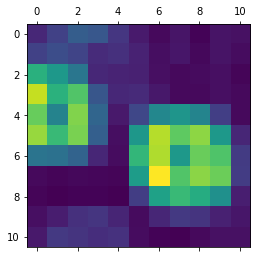

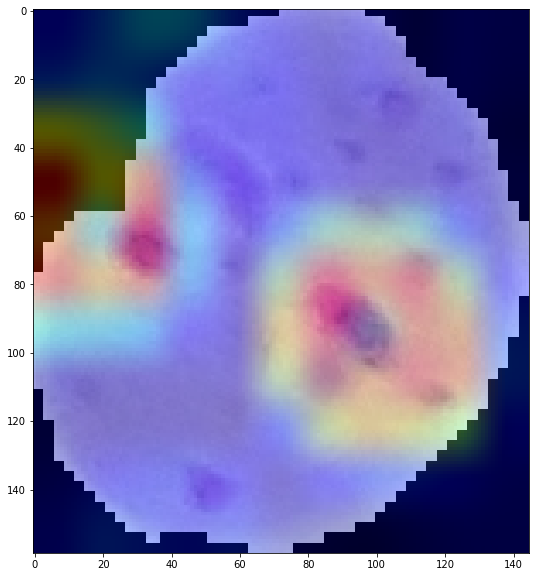

In [ ]:
cam_img = cam_pipeline(img, 'cam2.jpg', image2)
plt.figure(figsize= (10,10))
plt.imshow(cam_img)

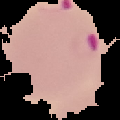

In [ ]:
image3_name = 'sample4.png'
image3 = ks.utils.get_file(fname=image3_name , origin='https://knowyourdata-tfds.withgoogle.com/serve_image?id=train%5B0shard%5D_3144&segment_name=default_segment&pipeline_id=20220622-99c6dc&cachebust=QZFKP8lK&dataset=malaria')

img = ks.utils.load_img(image3, target_size=(120,120))
array = ks.utils.img_to_array(img)
array = np.expand_dims(array, axis=0)

img

1/1 [==============================] - 0s 27ms/step


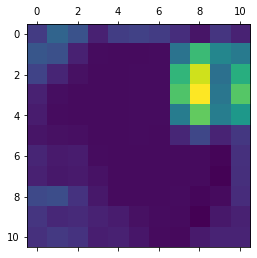

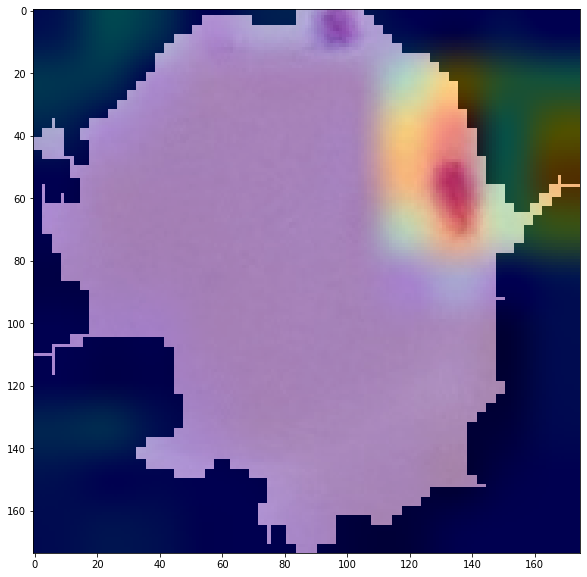

In [ ]:
cam_img = cam_pipeline(img, 'cam4.jpg', image3)
plt.figure(figsize= (10,10))
plt.imshow(cam_img)